In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [3]:
SYMBOLS = ['DIVING_GEAR']
OBSERVATIONS = ['DOLPHIN_SIGHTINGS']

# DATA LOADING

In [4]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in SYMBOLS + OBSERVATIONS:
        if s in df_grouped.groups:     
            markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        if not sym in hist_trades:
            continue
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [5]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size


def quote_weighted_px_square(quote, levels=5):
    notional, size = 0, 0
    for x in ['bid','ask']:
        notional += np.square(quote[f'{x}_sz'])*quote[x]
        size += np.square(quote[f'{x}_sz'])
   
        for i in range(2, min(quote[f'{x}_levels'], levels)+1):
            notional += quote[f'{x}_{i}']*np.square(quote[f'{x}_sz_{i}'])
            size += np.square(quote[f'{x}_sz_{i}'])
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

## Features

In [6]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 5, 10, 25, 50, 100, 200, 300, 400, 500]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in MOVING_WINDOW_TIMES:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
        md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'bid_move_{t}'].fillna(0, inplace=True)
        md[f'ask_move_{t}'].fillna(0, inplace=True)
        
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [7]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 
            'px_move_1': ['mean','std'],
            'px_move_10': ['mean','std'], 'px_move_50': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)
    for sym in OBSERVATIONS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'mid_price': ['mean','std','min','max']
        }).round(2)
        display(quote_summary)
        
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

## Load

In [8]:
data_dir = 'hist_data/island-data-bottle-round-3/'
hist_days = [0, 1, 2]
quote_files = [f'{data_dir}prices_round_3_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_3_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, hist_days)
for sym in ['DIVING_GEAR']:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [9]:
hist_data_summary(hist_quotes, hist_trades)

DIVING_GEAR


,spread,mid_price,px_move_1,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.46,99401.10,0.01,0.06,0.33,0.14,0.07,14.8,15.0,1.51,1.5,15.03,14.97,14.89,NaN
std,0.52,400.83,6.22,20.03,46.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,NaN,4135.00,2098.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DOLPHIN_SIGHTINGS


,mid_price
mean,3057.70
std,29.61
min,2992.00
max,3121.00


# Historical Quote Analysis

DIVING_GEAR


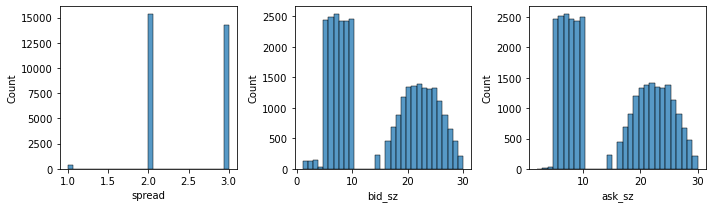

In [10]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

DIVING_GEAR


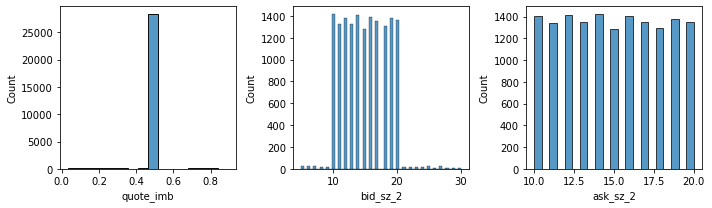

In [11]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['quote_imb','bid_sz_2','ask_sz_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

DIVING_GEAR


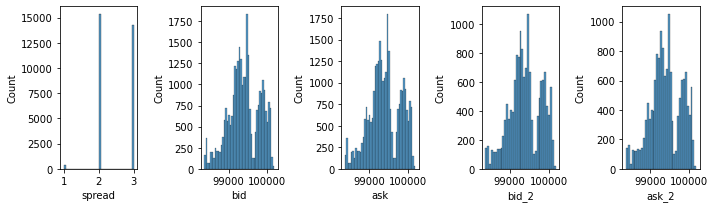

In [12]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

DIVING_GEAR


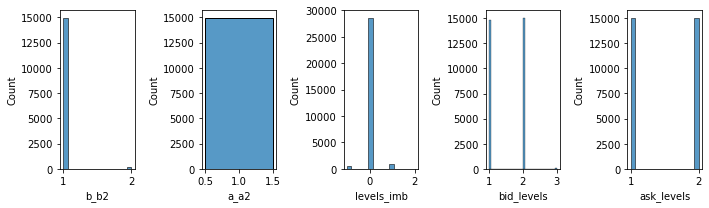

In [13]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    quote['b_b2'] = quote['bid'] - quote['bid_2']
    quote['a_a2'] = quote['ask_2'] - quote['ask']
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['b_b2','a_a2','levels_imb', 'bid_levels', 'ask_levels']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

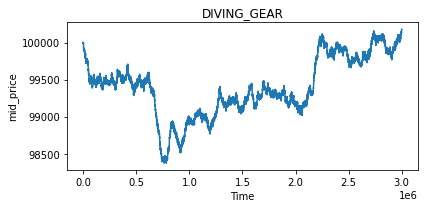

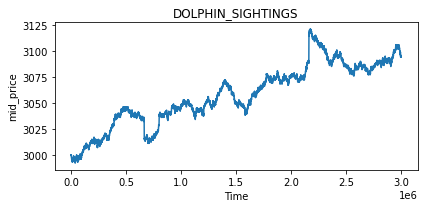

In [14]:
for sym in SYMBOLS + OBSERVATIONS:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

In [806]:
quote.loc[quote.day == 2].tail()

,day,timestamp,symbol,bid,bid_sz,bid_2,bid_sz_2,bid_3,bid_sz_3,ask,...,fair_v3_move_20,fair_v3_move_30,fair_v3_move_50,bid_improve,bid_revert,ask_improve,ask_revert,time,DOLPHIN_SIGHTINGS,signal
29995,2,2999500,DIVING_GEAR,100173.0,25.0,NaN,NaN,NaN,NaN,100176.0,...,45.5,41.0,50.5,True,False,False,True,29995.0,3094.0,0.0
29996,2,2999600,DIVING_GEAR,100170.0,5.0,100169.0,14.0,NaN,NaN,100172.0,...,38.5,44.0,47.5,False,True,True,False,29996.0,3094.0,0.0
29997,2,2999700,DIVING_GEAR,100178.0,23.0,NaN,NaN,NaN,NaN,100181.0,...,51.0,56.0,57.5,True,False,False,True,29997.0,3094.0,0.0
29998,2,2999800,DIVING_GEAR,100181.0,9.0,100180.0,18.0,NaN,NaN,100183.0,...,52.0,47.0,66.5,True,False,False,True,29998.0,3094.0,0.0
29999,2,2999900,DIVING_GEAR,100178.0,28.0,NaN,NaN,NaN,NaN,100181.0,...,49.0,54.5,59.5,False,True,True,False,29999.0,3094.0,0.0


# Historical Trade Analysis

In [15]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades['quantity'].describe().rename(sym))
print("DATA PER TRADE")
pd.concat(summ,axis=1).transpose()

DATA PER TRADE


,count,mean,std,min,25%,50%,75%,max
DIVING_GEAR,2098.0,1.970925,0.822092,1.0,1.0,2.0,3.0,3.0


In [16]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades.groupby('timestamp')['quantity'].sum().describe().rename(sym))
print("DATA PER STATE")
pd.concat(summ,axis=1).transpose()

DATA PER STATE


,count,mean,std,min,25%,50%,75%,max
DIVING_GEAR,2069.0,1.99855,0.864907,1.0,1.0,2.0,3.0,6.0


DIVING_GEAR


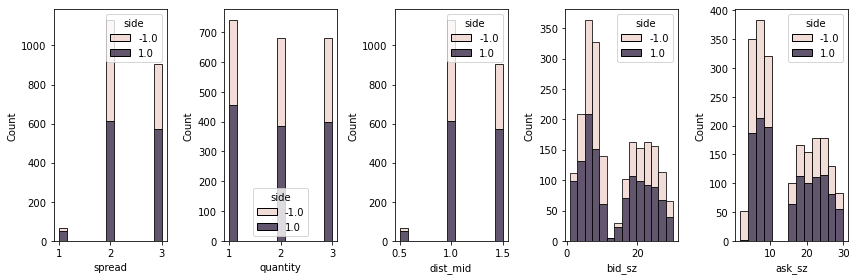

In [17]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['spread'] = trades['ask']-trades['bid']
    trades['dist_mid'] = np.abs(trades['mid_price']-trades['price'])
    
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','quantity', 'dist_mid', 'bid_sz','ask_sz']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

DIVING_GEAR


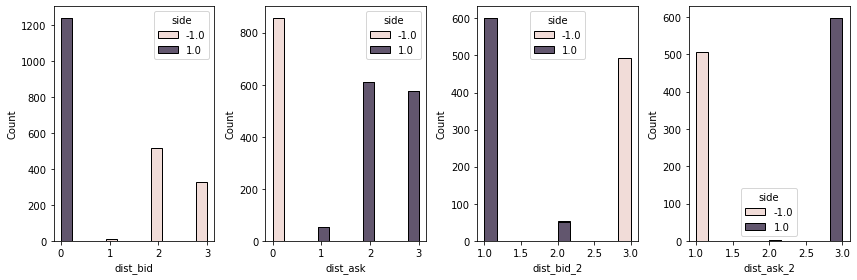

In [18]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['dist_bid'] = trades['price']-trades['bid']
    trades['dist_ask'] = trades['ask']-trades['price']
    
    trades['dist_bid_2'] = trades['price']-trades['bid_2']
    trades['dist_ask_2'] = trades['ask_2']-trades['price']
    
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(12,4))
    for i, col in enumerate(['dist_bid','dist_ask','dist_bid_2','dist_ask_2']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

# Dolphin Sighting Analysis

In [59]:
mid_labels, bid_labels, ask_labels,px_delta_cols = [], [], [], []

for t in FUTURE_TIMES:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [36]:
quote = hist_quotes['DIVING_GEAR'].copy()
quote['time'] = quote['timestamp']/100
quote['DOLPHIN_SIGHTINGS'] = hist_quotes['DOLPHIN_SIGHTINGS']['mid_price']

trades = hist_trades['DIVING_GEAR']
trades['time'] = trades['timestamp']/100

In [267]:
dolphin_diff = quote['DOLPHIN_SIGHTINGS'].diff(1).fillna(0)
pd.DataFrame(dolphin_diff.value_counts().sort_index()).transpose()

,-19.0,-4.0,-2.0,-1.0,0.0,1.0,3.0,4.0,5.0,8.0,9.0,26.0
DOLPHIN_SIGHTINGS,1,1,1,3397,23139,3452,4,1,1,1,1,1


<AxesSubplot:>

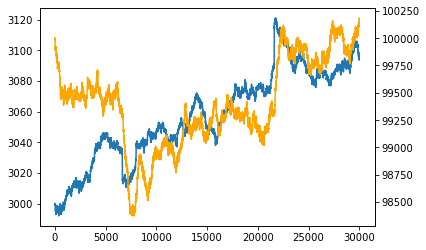

In [405]:
f,ax=plt.subplots()
idx = 30000
quote['DOLPHIN_SIGHTINGS'][:idx].plot(ax=ax)
ax2 = ax.twinx()
quote['mid_price'][:idx].plot(ax=ax2, color='orange')

## Ichimoku Cloud

In [760]:
# Coding ichimoku cloud
win1 = 25
win2 = 75
win3 = win2*2
quote['ichi_conversion'] = (quote['DOLPHIN_SIGHTINGS'].rolling(win1, min_periods=0).max()
                            +quote['DOLPHIN_SIGHTINGS'].rolling(win1, min_periods=0).min())/2

quote['ichi_base'] = (quote['DOLPHIN_SIGHTINGS'].rolling(win2, min_periods=0).max()
                            +quote['DOLPHIN_SIGHTINGS'].rolling(win2, min_periods=0).min())/2
quote['ichi_spanA'] = (quote['ichi_base'] + quote['ichi_conversion'])/2
quote['ichi_spanB'] = (quote['DOLPHIN_SIGHTINGS'].rolling(win3, min_periods=0).max()
                            +quote['DOLPHIN_SIGHTINGS'].rolling(win3, min_periods=0).min())/2

quote['ichi_lag'] = quote['DOLPHIN_SIGHTINGS'].shift(-win2)

quote['lead'] = quote['ichi_conversion']-quote['ichi_base']
quote['cloud'] = quote['ichi_spanA']-quote['ichi_spanB']

quote['px_base'] = quote['DOLPHIN_SIGHTINGS'] - quote['ichi_base']
quote['px_spanA'] = quote['DOLPHIN_SIGHTINGS'] - quote['ichi_spanA']
# quote.loc[quote['cloud'] < 0, 'px_spanA'] = 0

quote['px_spanB'] = quote['DOLPHIN_SIGHTINGS'] - quote['ichi_spanB']
# quote.loc[quote['cloud'] > 0, 'px_spanB'] = 0

quote['long_position'] = 0
quote['short_position'] = 0

# Enters
enter_long = (quote['lead'] == 0) & (quote['cloud'] > 0) & \
    (quote['DOLPHIN_SIGHTINGS'] >= quote['ichi_spanA']) & (quote['DOLPHIN_SIGHTINGS'] >= quote['ichi_spanB'])
quote['buy_px']  = quote[enter_long]['mid_price']
enter_short = (quote['lead'] == 0) & (quote['cloud'] < 0) &\
    (quote['DOLPHIN_SIGHTINGS'] <= quote['ichi_spanA']) & (quote['DOLPHIN_SIGHTINGS'] <= quote['ichi_spanB'])
quote['sell_px'] = quote[enter_short]['mid_price']


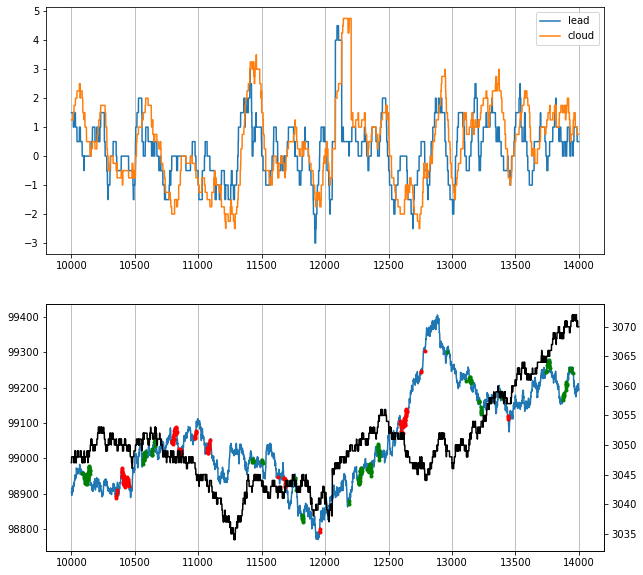

In [782]:
f, ax = plt.subplots(2,figsize=(10,10))

# data = quote[3500:6000].copy()
# data = quote[6500:8500].copy()
data = quote[10000:14000].copy()
# data = quote[13000:17000].copy()

# # data = quote[20000:25000].copy()
# data = quote[27000:28000].copy()


# for col in ['DOLPHIN_SIGHTINGS','ichi_conversion', 'ichi_base']:
#     ax[0].plot('time', col, data=data, label=col)
for col in ['lead','cloud']:
    ax[0].plot('time', col, data=data, label=col)
# for col in ['px_spanA', 'px_spanB']:
    # ax[0].plot('time', col, data=data, label=col, linestyle='--')
    
ax[0].grid(axis='x')
    
ax[0].legend()
ax[1].plot('time','mid_price',data=data)

ax[1].plot('time','buy_px',data=data,marker='.',color='green')
ax[1].plot('time','sell_px',data=data,marker='.',color='red')
ax[1].grid(axis='x')

ax2 = ax[1].twinx()
ax2.plot('time', 'DOLPHIN_SIGHTINGS', data=data, label='DOLPHIN_SIGHTINGS', color='black')

In [783]:
# last few unique
changes = dolphin_diff.loc[dolphin_diff != 0].copy()
dolphin_unique = quote.loc[dolphin_diff != 0, 'DOLPHIN_SIGHTINGS'].copy()
quote.drop('signal', axis=1,inplace=True)
# changes = np.sign(changes)
# quote['signal'] = changes.rolling(10).sum()-changes.rolling(20).sum()
# macd
# quote['signal'] = changes.rolling(3, min_periods=0).sum()-changes.rolling(10, min_periods=0).sum()

# Change in direction

# quote['signal'] = quote['DOLPHIN_SIGHTINGS'].rolling(5, min_periods=0).mean()-quote['DOLPHIN_SIGHTINGS'].rolling(10, min_periods=0).mean()

# emacd
quote['signal'] = quote['DOLPHIN_SIGHTINGS'].ewm(10, min_periods=0).mean()-quote['DOLPHIN_SIGHTINGS'].ewm(100, min_periods=0).mean()


# quote['signal'] = quote['DOLPHIN_SIGHTINGS']-quote['DOLPHIN_SIGHTINGS'].ewm(10, min_periods=0).mean()
# quote['signal'] = quote['DOLPHIN_SIGHTINGS']-dolphin_unique.ewm(10, min_periods=0).mean()

# quote['signal'].fillna(method='ffill', inplace=True)


KeyError: "['signal'] not found in axis"

In [307]:
# change_up = dolphin_diff.copy()
# change_down = dolphin_diff.copy()

# change_up[change_up<0] = 0
# change_down[change_down>0] = 0

# # Calculate the rolling average of average up and average down
# # avg_up = change_up.rolling(30).mean()
# # avg_down = change_down.rolling(30).mean().abs()

# avg_up = change_up.ewm(50).mean()
# avg_down = change_down.ewm(50).mean().abs()

# rsi = 100 - (100 / (1 + (avg_up / avg_down)))
# quote['signal'] = rsi
# quote['signal'] = dolphin_diff.loc[dolphin_diff != 0].rolling(20, min_periods=0).sum()
# quote['signal'].fillna(0, inplace=True)

KeyError: 'signal'

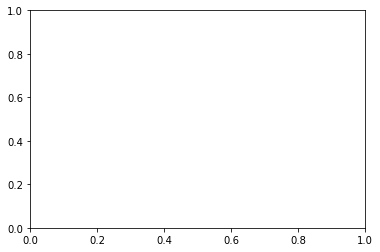

In [398]:
idx = 30000

f,ax=plt.subplots()
quote['signal'][:idx].plot(ax=ax)
ax.hlines(y=4, xmin=0, xmax=idx,color='black')
ax.hlines(y=-4, xmin=0, xmax=idx,color='black')
# ax.set_ylim(-5, 5)

ax2 = ax.twinx()
quote['mid_price'][:idx].plot(ax=ax2, color='orange')
ax3 = ax.twinx()
quote['DOLPHIN_SIGHTINGS'][:idx].plot(ax=ax3, color='grey')


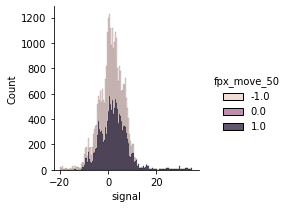

In [355]:
# sns.displot(x='signal', data=quote.loc[np.abs(quote['signal']) >= 1],hue='fpx_move_50',multiple='stack', height=3)
sns.displot(x='signal', data=quote,hue='fpx_move_50',multiple='stack', height=3)

In [686]:
sub_data = quote.copy()
# sub_data = sub_data.loc[np.abs(sub_data.signal) >= 1]

print("{} {} {} {:.2f}%".format('DIVING_GEAR', len(quote.copy()), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['lead'] + px_delta_cols].corr()
display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

DIVING_GEAR 30000 30000 100.00%


,lead,fpx_1,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_300,fpx_400,fpx_500
lead,1.000,0.011,0.022,0.030,0.051,0.075,0.121,0.173,0.196,0.222,0.238
fpx_1,0.011,1.000,0.454,0.321,0.205,0.145,0.104,0.083,0.068,0.059,0.052
fpx_5,0.022,0.454,1.000,0.713,0.457,0.323,0.230,0.184,0.153,0.132,0.116
fpx_10,0.030,0.321,0.713,1.000,0.645,0.454,0.323,0.257,0.215,0.187,0.164
fpx_25,0.051,0.205,0.457,0.645,1.000,0.721,0.507,0.397,0.337,0.290,0.259
fpx_50,0.075,0.145,0.323,0.454,0.721,1.000,0.713,0.550,0.467,0.407,0.361
fpx_100,0.121,0.104,0.230,0.323,0.507,0.713,1.000,0.757,0.652,0.570,0.508
fpx_200,0.173,0.083,0.184,0.257,0.397,0.550,0.757,1.000,0.865,0.776,0.698
fpx_300,0.196,0.068,0.153,0.215,0.337,0.467,0.652,0.865,1.000,0.907,0.833
fpx_400,0.222,0.059,0.132,0.187,0.290,0.407,0.570,0.776,0.907,1.000,0.930


## Finding trend line for dolphin sightings

In [365]:
from sklearn.linear_model import LinearRegression, Ridge

In [339]:
start = 0
end = start + 10000

train_quote = quote.iloc[start:end].reset_index(drop=True)

X = np.arange(end-start)
y = train_quote['DOLPHIN_SIGHTINGS'].copy()
y -= y.iat[0]
y = y.values

# reg = LinearRegression(fit_intercept=False).fit(X, y)
# print(reg.score(X,y), reg.coef_, reg.intercept_)
# prediction = reg.predict(X)
prediction = np.multiply(X, 32.5/10000)+10 # day 1

# prediction = np.multiply(X, 25/10000)-11 # day 2
# prediction = np.multiply(X, 25/10000)-16 # day 3


train_quote['prediction'] = prediction
train_quote['signal'] = y - prediction
train_quote['signal'] = train_quote['signal'] - train_quote['signal'].rolling(5, min_periods=0).mean()
# train_quote['signal'] = train_quote['signal']

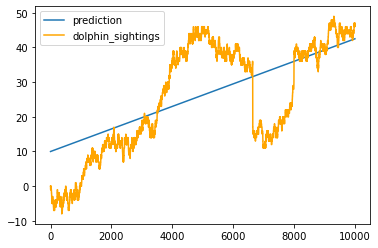

In [340]:
f, ax = plt.subplots()

ax.plot(train_quote['prediction'], label='prediction')

# ax2 = ax.twinx()
ax.plot(y, label='dolphin_sightings', color='orange')
ax.legend()

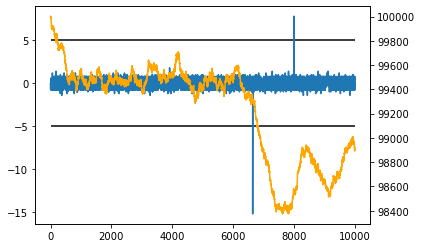

In [341]:
f, ax = plt.subplots()
ax.plot(train_quote['signal'], label='signal')

bounds = 5
ax.hlines(bounds, xmin = 0, xmax=10000, color='black')
ax.hlines(0, xmin = 0, xmax=10000, color='black')
ax.hlines(-bounds, xmin = 0, xmax=10000, color='black')

ax2 = ax.twinx()
ax2.plot(train_quote['mid_price'], label='diving_price', color='orange')
# # ax2.plot(train_quote['vwap'], label='diving_price', color='black')
# ax2.plot('time','price', data=trades, color='black')

In [576]:
sub_data = train_quote.copy()
sub_data = sub_data.loc[np.abs(sub_data.signal) >= 2]
sub_data = sub_data.loc[sub_data.signal > 0]

print("{} {} {} {:.2f}%".format('DIVING_GEAR', len(quote.copy()), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'fair_v1_move_1', 'signal'] + px_delta_cols].corr()
display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

DIVING_GEAR 30000 9832 32.77%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,signal,fpx_1,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_300,fpx_400,fpx_500
quote_imb,1.000,-0.944,0.926,0.008,-0.013,0.012,0.008,-0.002,-0.012,-0.016,-0.015,-0.009,-0.008,-0.001,0.002
levels_imb,-0.944,1.000,-0.880,-0.007,0.011,-0.008,-0.008,0.003,0.016,0.017,0.018,0.011,0.007,-0.001,-0.003
dist_fair_v1,0.926,-0.880,1.000,0.007,-0.011,0.013,0.008,-0.006,-0.014,-0.011,-0.011,-0.004,-0.002,0.004,0.007
fair_v1_move_1,0.008,-0.007,0.007,1.000,0.021,0.005,0.012,-0.005,0.012,0.006,-0.009,0.017,0.008,0.012,0.013
signal,-0.013,0.011,-0.011,0.021,1.000,0.021,0.047,0.065,0.102,0.147,0.203,0.230,0.221,0.185,0.147
fpx_1,0.012,-0.008,0.013,0.005,0.021,1.000,0.451,0.312,0.209,0.142,0.091,0.084,0.063,0.057,0.053
fpx_5,0.008,-0.008,0.008,0.012,0.047,0.451,1.000,0.708,0.458,0.314,0.204,0.185,0.140,0.127,0.118
fpx_10,-0.002,0.003,-0.006,-0.005,0.065,0.312,0.708,1.000,0.642,0.442,0.290,0.257,0.197,0.178,0.168
fpx_25,-0.012,0.016,-0.014,0.012,0.102,0.209,0.458,0.642,1.000,0.716,0.464,0.391,0.304,0.271,0.261
fpx_50,-0.016,0.017,-0.011,0.006,0.147,0.142,0.314,0.442,0.716,1.000,0.683,0.540,0.423,0.381,0.364


0.09762476745132354 [ 7.63805789 -0.03438093] 76306.81432364802


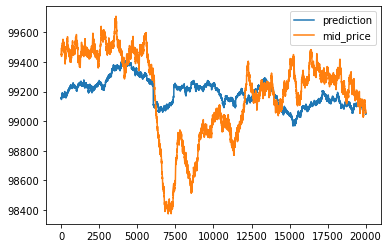

In [594]:
start = 600
end = start + 20000

train_quote = quote.iloc[start:end].reset_index(drop=True)
# train_quote['time'] = train_quote.index.values

# train_quote['DOLPHIN_SIGHTINGS'] -= train_quote['DOLPHIN_SIGHTINGS'].iat[0]
X = train_quote[['DOLPHIN_SIGHTINGS','time']].values
y = train_quote['mid_price']
y = y.values

reg = LinearRegression(fit_intercept=True).fit(X, y)
print(reg.score(X,y), reg.coef_, reg.intercept_)
prediction = reg.predict(X)

train_quote['prediction'] = prediction
# train_quote['signal'] = y - prediction
train_quote['signal'] = train_quote['prediction']

f, ax = plt.subplots()
ax.plot(train_quote['prediction'], label='prediction')
ax.plot(y, label='mid_price')
ax.legend()

-11.034785512488401 [ 7.63805789 -0.03438093] 76306.81432364802


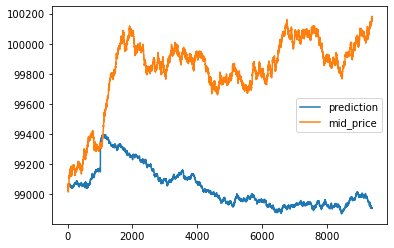

In [595]:
test_start = end

test_quote = quote.iloc[test_start:].reset_index(drop=True)
# test_quote['time'] = test_quote.index.values

# test_quote['DOLPHIN_SIGHTINGS']-= test_quote['DOLPHIN_SIGHTINGS'].iat[0]
X = test_quote[['DOLPHIN_SIGHTINGS','time']].values
y = test_quote['mid_price']
# -test_quote['mid_price'].iat[0]
y = y.values

# reg = LinearRegression(fit_intercept=True).fit(X, y)
print(reg.score(X,y), reg.coef_, reg.intercept_)
prediction = reg.predict(X)

test_quote['prediction'] = prediction
test_quote['signal'] = train_quote['prediction']

f, ax = plt.subplots()
ax.plot(test_quote['prediction'], label='prediction')
ax.plot(y, label='mid_price')
ax.legend()

## Model

In [395]:
# last few unique
changes = dolphin_diff.loc[dolphin_diff != 0].copy()
dolphin_unique = quote.loc[dolphin_diff != 0, 'DOLPHIN_SIGHTINGS'].copy()
# changes = np.sign(changes)

quote['dolphin_return'] = quote['DOLPHIN_SIGHTINGS']/quote['DOLPHIN_SIGHTINGS'].shift(5) -1
# quote['signal'] = changes.rolling(10).sum()-changes.rolling(20).sum()
# macd
quote['macd'] = changes.rolling(3, min_periods=0).sum()-changes.rolling(10, min_periods=0).sum()

# Change in direction

# quote['signal'] = quote['DOLPHIN_SIGHTINGS'].rolling(5, min_periods=0).mean()-quote['DOLPHIN_SIGHTINGS'].rolling(10, min_periods=0).mean()

# emacd
quote['emacd1'] = quote['DOLPHIN_SIGHTINGS'].ewm(10, min_periods=0).mean()-quote['DOLPHIN_SIGHTINGS'].ewm(100, min_periods=0).mean()
quote['emacd2'] = quote['DOLPHIN_SIGHTINGS']-quote['DOLPHIN_SIGHTINGS'].ewm(10, min_periods=0).mean()
quote['emacd3'] = quote['DOLPHIN_SIGHTINGS']-dolphin_unique.ewm(10, min_periods=0).mean()


for f in ['macd','emacd1','emacd2','emacd3']:
    quote[f] = quote[f].fillna(method='ffill').fillna(0)
# quote['signal'].fillna(method='ffill', inplace=True)


<AxesSubplot:>

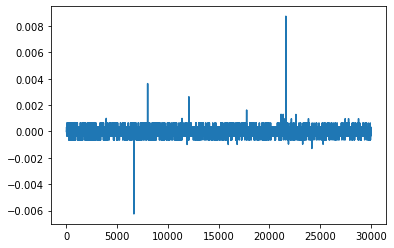

In [397]:
quote['dolphin_return'].plot()

In [385]:
quote['time'] = quote.index.values
quote['norm_price'] = quote['mid_price']-100000

0.9976471591153633 [ 9.997027e-01 -6.953400e-02 -1.830000e-05] 0.0


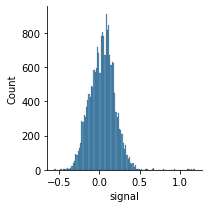

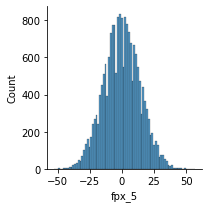

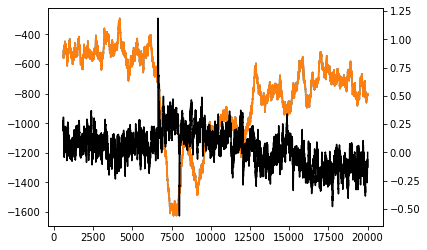

In [391]:
start = 600
end = 20000

features = ['norm_price', 'emacd3', 'time']
target = 'norm_price'
prediction_horizon = 5

train_quote = quote.iloc[start:end].reset_index(drop=True)
X = train_quote[features].values
y = (train_quote[target].shift(-prediction_horizon)).values
X = X[:-prediction_horizon]
y = y[:-prediction_horizon]

# reg = LinearRegression(fit_intercept=False).fit(X, y)
reg = Ridge(fit_intercept=False).fit(X, y)
reg.coef_ = np.round(reg.coef_, 7)
print(reg.score(X,y), reg.coef_, reg.intercept_)
prediction = reg.predict(X)

train_quote['prediction'] = train_quote[target]
train_quote.loc[train_quote.index[:-prediction_horizon], 'prediction'] = prediction
train_quote['signal'] = train_quote['prediction']-train_quote[target]
# train_quote['signal'] = train_quote['signal']
sns.displot(train_quote['signal'],height=3)

sns.displot(train_quote[f'fpx_{prediction_horizon}'],height=3)
# sns.lmplot(x="signal", y=f'fpx_{prediction_horizon}', data=train_quote, line_kws={'color': 'red'})

f, ax = plt.subplots()
ax.plot('time','prediction',data=train_quote,label='pred')
ax.plot('time',target,data=train_quote, label='target')
ax.twinx().plot('time','signal',data=train_quote, color='black')

In [393]:
sub_data = train_quote.copy()
total_samples = len(sub_data)
# sub_data = sub_data.loc[np.abs(sub_data.signal) > 1]
analysis_samples = len(sub_data)

print("{} {} {} {:.2f}%".format('DIVING_GEAR', analysis_samples, total_samples, 100*analysis_samples/total_samples))
corr = sub_data[['signal'] + px_delta_cols + mid_labels].corr()
display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

DIVING_GEAR 19400 19400 100.00%


,signal,fpx_1,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_300,fpx_400,fpx_500,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100,fpx_move_200,fpx_move_300,fpx_move_400,fpx_move_500
signal,1.000,0.005,0.013,0.016,0.012,0.015,-0.003,-0.038,-0.029,-0.031,-0.022,0.007,0.005,0.004,-0.002,0.003,0.012,0.026,0.031,0.027,0.005
fpx_1,0.005,1.000,0.455,0.323,0.202,0.144,0.106,0.080,0.068,0.056,0.048,0.810,0.367,0.263,0.159,0.114,0.081,0.061,0.049,0.043,0.032
fpx_5,0.013,0.455,1.000,0.714,0.454,0.320,0.236,0.178,0.152,0.126,0.106,0.367,0.805,0.575,0.364,0.253,0.175,0.140,0.116,0.100,0.069
fpx_10,0.016,0.323,0.714,1.000,0.642,0.452,0.331,0.252,0.214,0.179,0.151,0.264,0.575,0.803,0.512,0.367,0.249,0.199,0.166,0.144,0.095
fpx_25,0.012,0.202,0.454,0.642,1.000,0.716,0.515,0.390,0.337,0.279,0.240,0.166,0.365,0.520,0.804,0.578,0.405,0.296,0.266,0.226,0.154
fpx_50,0.015,0.144,0.320,0.452,0.716,1.000,0.715,0.542,0.471,0.395,0.339,0.125,0.259,0.376,0.581,0.807,0.573,0.413,0.368,0.313,0.231
fpx_100,-0.003,0.106,0.236,0.331,0.515,0.715,1.000,0.759,0.651,0.559,0.482,0.092,0.195,0.282,0.424,0.574,0.801,0.585,0.507,0.426,0.342
fpx_200,-0.038,0.080,0.178,0.252,0.390,0.542,0.759,1.000,0.867,0.771,0.680,0.071,0.147,0.210,0.317,0.426,0.588,0.776,0.655,0.575,0.492
fpx_300,-0.029,0.068,0.152,0.214,0.337,0.471,0.651,0.867,1.000,0.908,0.825,0.057,0.124,0.179,0.282,0.380,0.510,0.661,0.771,0.682,0.606
fpx_400,-0.031,0.056,0.126,0.179,0.279,0.395,0.559,0.771,0.908,1.000,0.928,0.046,0.102,0.149,0.238,0.312,0.434,0.571,0.678,0.755,0.686


0.9975169460662587 [ 9.980799e-01 -5.641000e-04] 0.0


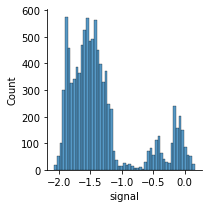

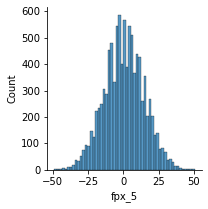

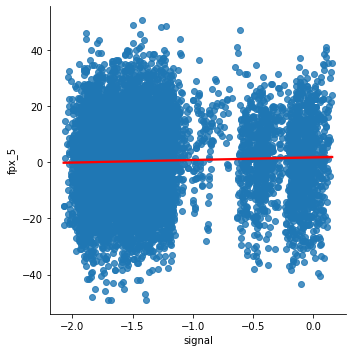

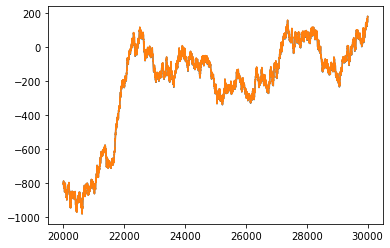

In [369]:
test_start = end
test_quote = quote.iloc[test_start:].reset_index(drop=True)

X = test_quote[features].values
y = (test_quote[target].shift(-prediction_horizon)).values
X = X[:-prediction_horizon]
y = y[:-prediction_horizon]

# reg = LinearRegression(fit_intercept=True).fit(X, y)
print(reg.score(X,y), reg.coef_, reg.intercept_)
prediction = reg.predict(X)

test_quote['prediction'] = test_quote[target]
test_quote.loc[test_quote.index[:-prediction_horizon], 'prediction'] = prediction
test_quote['signal'] = test_quote['prediction']-test_quote[target]
# test_quote['signal'] = test_quote['signal']
sns.displot(test_quote['signal'],height=3)

sns.displot(test_quote[f'fpx_{prediction_horizon}'],height=3)
sns.lmplot(x="signal", y=f'fpx_{prediction_horizon}', data=test_quote, line_kws={'color': 'red'})

f, ax = plt.subplots()
ax.plot('time','prediction',data=test_quote,label='pred')
ax.plot('time',target,data=test_quote, label='target')

In [371]:
sub_data = test_quote.copy()
total_samples = len(sub_data)
sub_data = sub_data.loc[np.abs(sub_data.signal) > 1]
analysis_samples = len(sub_data)

print("{} {} {} {:.2f}%".format('DIVING_GEAR', analysis_samples, total_samples, 100*analysis_samples/total_samples))
corr = sub_data[['signal'] + px_delta_cols +mid_labels].corr()
display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

DIVING_GEAR 8183 10000 81.83%


,signal,fpx_1,fpx_5,fpx_10,fpx_25,fpx_50,fpx_100,fpx_200,fpx_300,fpx_400,fpx_500,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100,fpx_move_200,fpx_move_300,fpx_move_400,fpx_move_500
signal,1.000,0.027,0.060,0.085,0.133,0.184,0.232,0.302,0.361,0.408,0.446,0.016,0.047,0.060,0.086,0.130,0.142,0.205,0.267,0.327,0.349
fpx_1,0.027,1.000,0.451,0.311,0.208,0.140,0.091,0.081,0.063,0.055,0.052,0.810,0.372,0.241,0.165,0.128,0.063,0.071,0.056,0.043,0.044
fpx_5,0.060,0.451,1.000,0.706,0.456,0.310,0.204,0.179,0.141,0.125,0.118,0.365,0.805,0.571,0.373,0.261,0.143,0.151,0.120,0.093,0.093
fpx_10,0.085,0.311,0.706,1.000,0.641,0.435,0.290,0.248,0.197,0.177,0.169,0.252,0.565,0.800,0.518,0.355,0.210,0.205,0.165,0.127,0.131
fpx_25,0.133,0.208,0.456,0.641,1.000,0.703,0.464,0.381,0.305,0.277,0.268,0.177,0.365,0.512,0.804,0.576,0.364,0.314,0.244,0.205,0.209
fpx_50,0.184,0.140,0.310,0.435,0.703,1.000,0.680,0.532,0.419,0.399,0.374,0.117,0.256,0.355,0.577,0.808,0.546,0.417,0.316,0.290,0.299
fpx_100,0.232,0.091,0.204,0.290,0.464,0.680,1.000,0.709,0.603,0.553,0.506,0.074,0.181,0.256,0.398,0.578,0.805,0.537,0.446,0.426,0.383
fpx_200,0.302,0.081,0.179,0.248,0.381,0.532,0.709,1.000,0.823,0.737,0.684,0.066,0.154,0.216,0.332,0.476,0.568,0.796,0.631,0.548,0.544
fpx_300,0.361,0.063,0.141,0.197,0.305,0.419,0.603,0.823,1.000,0.876,0.805,0.052,0.120,0.168,0.257,0.368,0.456,0.651,0.786,0.675,0.621
fpx_400,0.408,0.055,0.125,0.177,0.277,0.399,0.553,0.737,0.876,1.000,0.902,0.044,0.102,0.145,0.218,0.341,0.423,0.567,0.673,0.796,0.709


In [720]:
test_quote.loc[test_quote.signal > 0][px_delta_cols].mean()

fpx_1       0.098249
fpx_5       0.491296
fpx_10      0.980740
fpx_25      2.474387
fpx_50      4.994647
fpx_100    10.072586
fpx_200    20.319710
fpx_300    31.036018
fpx_400    41.544522
fpx_500    52.612156
dtype: float64

# Backtest Analysis

In [116]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})$")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")

    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    observations = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": 0, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            extract_observations(observations, state)
            
    positions = pd.DataFrame(positions)
    observations = pd.DataFrame(observations)
    
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths, observations

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_observations(observations, state):
    obs = state['observations']
    for p in obs:
        observations.append({"timestamp": state['timestamp'], "symbol": p, "observation": obs[p]})
        
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return


def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']
    
def fix_fill_volume(x):
    fill_qty = np.clip(x['fill_qty']-x['quantity'].cumsum()-x['quantity'].iat[0], 0, None)
    return fill_qty

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)

    gcols = ['symbol','timestamp','price','side']
    fill_data = fills.groupby(gcols)[['quantity']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    fill_data['i'] = 0
    orders['i'] = orders.groupby(gcols).cumcount()
    orders = orders.merge(fill_data, how='left', on=gcols+['i']).drop('i',axis=1)
    orders['fill_qty'].fillna(0, inplace=True)    
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby('symbol')[col].transform(pd.Series.cumsum)
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths, observations = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    dfs['observations'] = observations
    
    if by_symbol:
        for table in dfs:
            if not dfs[table].empty:
                dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [117]:
def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

## Load

DIVING_GEAR: PnL=-6169.0 | Trades=10.0 | MarketVol=164 | Volume Filled=100.0 | POV=0.38 | Shares/Step=0.1 | PnL/Share=-61.69
Total PnL=-6169.0


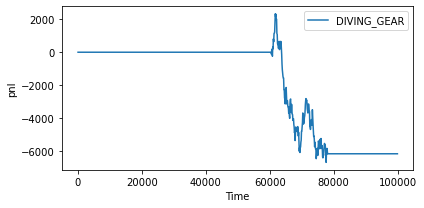

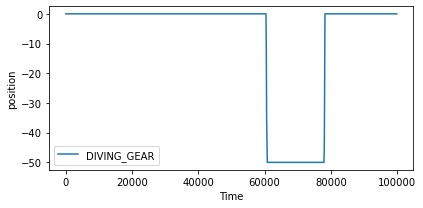

In [777]:
log_file = "backtest_logs/backtest.log"
log_file = "round3_logs/" + "9f0a81d1-39cf-4d46-bec8-8331680d1711.log"

dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

<AxesSubplot:>

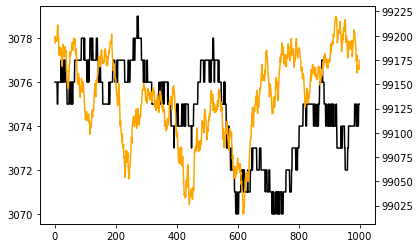

In [778]:
sim_dolphins = dfs['observations']['DOLPHIN_SIGHTINGS']['observation']
sim_quote = dfs['quote']['DIVING_GEAR']
ax=sim_dolphins.plot(color='black')
sim_quote['mid_price'].plot(ax=ax.twinx(),color='orange')

<AxesSubplot:>

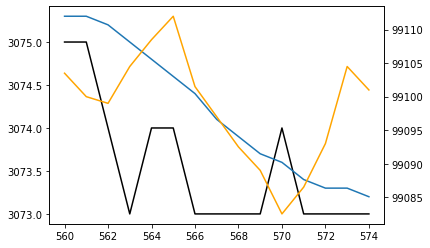

In [869]:
ax=sim_dolphins.iloc[560:575].plot(color='black')
sim_dolphins.rolling(10, min_periods=0, closed='right').mean().iloc[560:575].plot(ax=ax)
sim_quote['mid_price'].iloc[560:575].plot(ax=ax.twinx(),color='orange')

<AxesSubplot:>

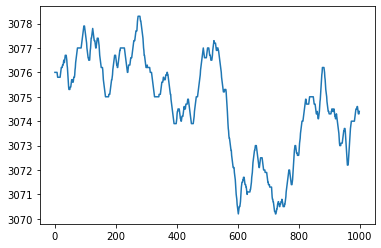